In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestRegressor  # or RandomForestRegressor for regression
from sklearn.model_selection import train_test_split

In [2]:
path_event_data_20_23 = 'UNSW Data/2020-2023 Event Data.csv'

In [3]:
df_event_data_20_23 = pd.read_csv(path_event_data_20_23)

/var/folders/00/ydtbsl791tsc26f__44qvf2w0000gq/T/ipykernel_38290/504862238.py:1: DtypeWarning: Columns (55,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df_event_data_20_23 = pd.read_csv(path_event_data_20_23)


In [4]:
df_event_data_20_23.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4619457 entries, 0 to 4619456
Data columns (total 77 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Anonymize 1PlayerId          object 
 1   Away Score                   int64  
 2   Captain                      object 
 3   ChannelPhysical              object 
 4   ChannelPlayer                object 
 5   ChannelPossession            object 
 6   Club Id                      object 
 7   Club Name                    object 
 8   Deidentified Away Club Id    object 
 9   Deidentified Away Club Name  object 
 10  Deidentified Club Home Id    object 
 11  Deidentified Club Home Name  object 
 12  DistanceMs                   float64
 13  DurationSecs                 float64
 14  ElapsedMillisecs             int64  
 15  ElapsedMins                  int64  
 16  ElapsedSecs                  int64  
 17  EventCode                    object 
 18  EventName                    object 
 19  

# Data Cleaning

### Filtering Data:

Our project centers on measuring play-the-ball speed and exploring the factors that influence it, as well as its impact on game and player outcomes. Consequently, we are focusing on a targeted subset of the dataset, specifically including only rows related to events that pertain to play-the-ball speed.

The only events associated with play-the-ball speed include:

| **EventCode** | **EventName**               |
|----------------|------------------------------|
| PBFD           | PTB by opp - fast            |
| PBFS           | PTB - fast                   |
| PBND           | PTB by opp - neutral         |
| PBNS           | PTB - neutral                |
| PBSD           | PTB by opp - slow            |
| PBSS           | PTB - slow                   |


In [5]:
ptb_speed_event_codes = ['PBFD', 'PBFS', 'PBND', 'PBNS', 'PBSD', 'PBSS'] 
ptb_speed_df = df_event_data_20_23[df_event_data_20_23['EventCode'].isin(ptb_speed_event_codes)]
print(f"Row count: {ptb_speed_df.shape[0]}")

Row count: 224054


It is important to note that the events labeled as "by opp" in the dataset may result in duplicates due to their nature of capturing events from both the team's and the opponent's perspective. Specifically, for any given play-the-ball event, both the original team and the opposing team may have entries reflecting the same event.

For instance, if Team A performs a play-the-ball that is recorded as "PTB by opp - fast" when viewed from Team B's perspective, Team A may also have a corresponding entry recorded as "PTB - fast." This duplication occurs because the same event is represented in the dataset from two different perspectives.

To maintain the integrity of our analysis on play-the-ball speed, we can remove the "by opp" rows. By doing this, we ensure that each unique play-the-ball event is only counted once, eliminating any potential redundancy and preventing skewed results in our measurements and assessments.

This can be observed in the table below using 'PTB by opp - fast' and 'PTB - fast' as an example.

In [6]:
events_of_interest = ['PTB - fast', 'PTB by opp - fast']
filtered_df = ptb_speed_df[ptb_speed_df['EventName'].isin(events_of_interest)]
filtered_df[['MatchId', 'Club Id', 'Opposition Id', 'GameMins', 'GameSecs', 'ElapsedMins', 'ElapsedSecs', 'DurationSecs', 'EventName']].head(10)

,MatchId,Club Id,Opposition Id,GameMins,GameSecs,ElapsedMins,ElapsedSecs,DurationSecs,EventName
213,20111032,0d68c832f3fa27f411e99d1b3985ce18,837e03d56b4dba3b8a4a5425c0420abd,1,6,1,6,0.76,PTB - fast
214,20111032,837e03d56b4dba3b8a4a5425c0420abd,0d68c832f3fa27f411e99d1b3985ce18,1,6,1,6,0.76,PTB by opp - fast
2002,20111032,0d68c832f3fa27f411e99d1b3985ce18,837e03d56b4dba3b8a4a5425c0420abd,15,16,16,32,1.80,PTB - fast
2003,20111032,837e03d56b4dba3b8a4a5425c0420abd,0d68c832f3fa27f411e99d1b3985ce18,15,16,16,32,1.80,PTB by opp - fast
4122,20111032,0d68c832f3fa27f411e99d1b3985ce18,837e03d56b4dba3b8a4a5425c0420abd,26,48,30,34,1.84,PTB - fast
4123,20111032,837e03d56b4dba3b8a4a5425c0420abd,0d68c832f3fa27f411e99d1b3985ce18,26,48,30,34,1.84,PTB by opp - fast
4640,20111032,0d68c832f3fa27f411e99d1b3985ce18,837e03d56b4dba3b8a4a5425c0420abd,30,35,34,20,1.96,PTB - fast
4641,20111032,837e03d56b4dba3b8a4a5425c0420abd,0d68c832f3fa27f411e99d1b3985ce18,30,35,34,20,1.96,PTB by opp - fast
5516,20111032,0d68c832f3fa27f411e99d1b3985ce18,837e03d56b4dba3b8a4a5425c0420abd,38,15,43,6,1.28,PTB - fast
5517,20111032,837e03d56b4dba3b8a4a5425c0420abd,0d68c832f3fa27f411e99d1b3985ce18,38,15,43,6,1.28,PTB by opp - fast


In [7]:
ptb_speed_opp_event_codes = ['PBFD', 'PBND', 'PBSD'] 
ptb_speed_df = ptb_speed_df[~ptb_speed_df['EventCode'].isin(ptb_speed_opp_event_codes)]
print(f"Row count: {ptb_speed_df.shape[0]}")
print(ptb_speed_df['EventName'].unique())

Row count: 112027
['PTB - neutral' 'PTB - fast' 'PTB - slow']


### Time Aggregation

There are two primary features for tracking time: the remaining time on the clock in the current half (*GameMins* and *GameSecs*) and the elapsed time since kickoff in the current half (*ElapsedMins*, *ElapsedSecs*, and *ElapsedMillisecs*). Both features have their nuanced significance. Remaining time informs teams’ strategies, motivating adjustments in play speed to intensify offensive pressure and influencing the urgency of players during play-the-ball situations. In contrast, elapsed time provides insight into player fatigue and pacing, which can significantly impact individual performance and overall team momentum.

We will consolidate each of these metrics into a single variable: GameTime and ElapsedTime, both represented as float64 types. This approach captures and combines the different units of time into minutes, making it easier to model and visualize temporal data while preserving detail and granularity.

However, we will eliminate *ElapsedMillisecs* from our time aggregation to simplify the time metric *ElapsedTime* for two reasons. Cognitive load theory suggests that by reducing complexity can enhance decision-making and performance particularly in high-pressure situations, such as sports. Simplifying the information (without being reductive but seconds is detailed enough in our context) can help athletes and coaches focus on critical decisions without being overwhelmed by unnecessary details (Sweller, 1988). Additionally, many sports performance analyses focus on broader time intervals that are more relevant ot the game's flow in which studies often aggregate data into seconds or minutes to identify trends and inform strategies (Hughes and Franks, 2004). It becomes impractical to base recommendations on miliseconds which may instead cause greater confusion and pressure, potentially impeding a team's ability to perform optimally.

Our approach to these time metrics aims to strike a balance between maintaining detail and avoiding unnecessary complexity.



*Sweller, J. (1988) ‘Cognitive load during problem solving: Effects on learning’, Cognitive Science, 12(2), pp. 257-285.*

*Hughes, M. and Franks, I. (2004) Notational Analysis of Sport: Systems for Better Coaching and Performance in Sport. London: Routledge.*

In [8]:
ptb_speed_df['GameTime'] = ptb_speed_df['GameMins'] + (ptb_speed_df['GameSecs'] / 60)
ptb_speed_df['ElapsedTime'] = ptb_speed_df['ElapsedMins'] + (ptb_speed_df['ElapsedSecs'] / 60)
ptb_speed_df[['GameTime', 'GameMins', 'GameSecs', 'ElapsedTime', 'ElapsedMins', 'ElapsedSecs']].head()

,GameTime,GameMins,GameSecs,ElapsedTime,ElapsedMins,ElapsedSecs
39,0.216667,0,13,0.216667,0,13
70,0.400000,0,24,0.400000,0,24
107,0.566667,0,34,0.566667,0,34
138,0.733333,0,44,0.733333,0,44
169,0.866667,0,52,0.866667,0,52


In [9]:
ptb_speed_df = ptb_speed_df.drop(['GameMins', 'GameSecs'], axis=1)
ptb_speed_df = ptb_speed_df.drop(['ElapsedMins', 'ElapsedSecs', 'ElapsedMillisecs'], axis=1)

With this streamlined representation of time metrics, it becomes much easier to depict data in a time series form to analyse trends and patterns. For example, it can be used to observe play-the-ball speed in over time in each half of the game as seen below.

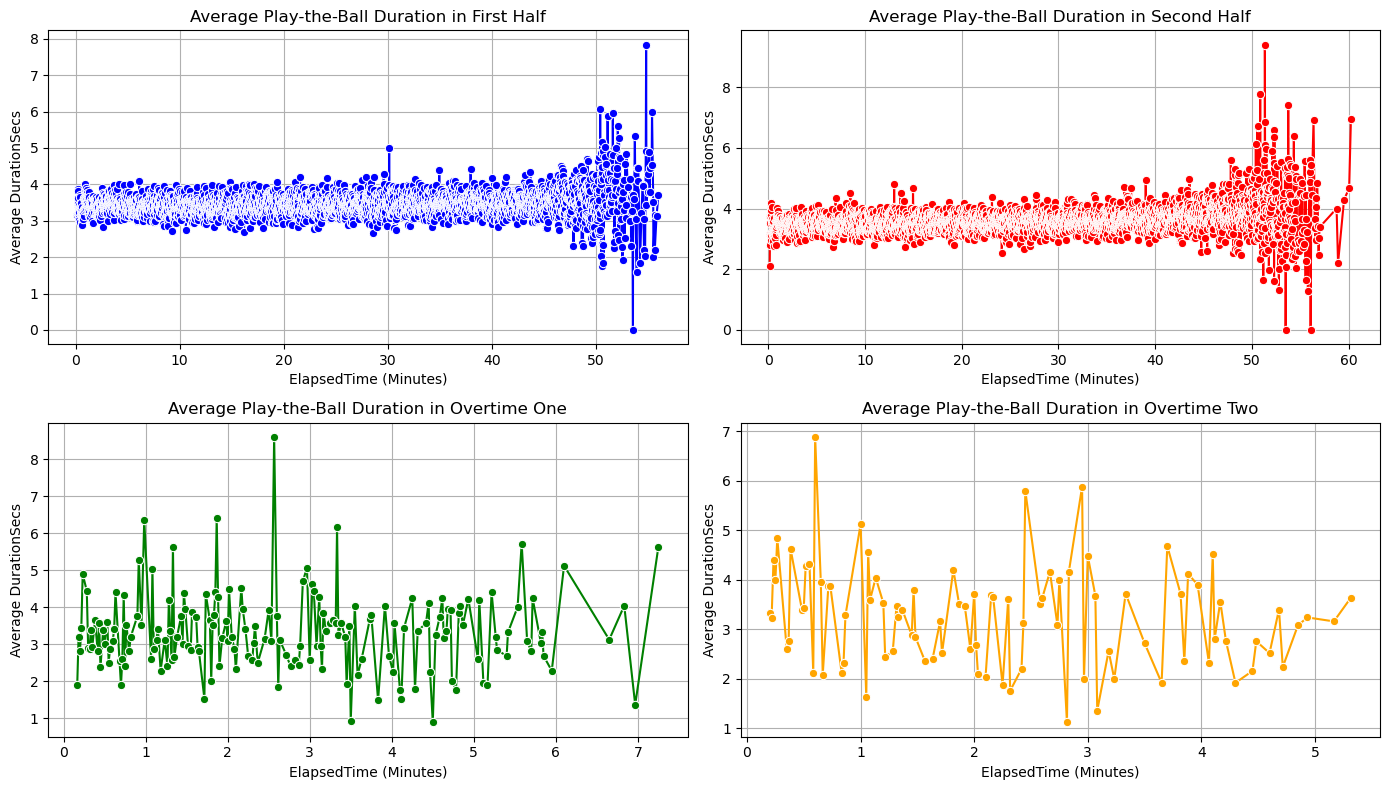

In [10]:
avg_duration_by_half = ptb_speed_df.groupby(['Half', 'ElapsedTime'])['DurationSecs'].mean().reset_index()

df_first_half = avg_duration_by_half[avg_duration_by_half['Half'] == 1]
df_second_half = avg_duration_by_half[avg_duration_by_half['Half'] == 2]
df_overtime_one = avg_duration_by_half[avg_duration_by_half['Half'] == 3]
df_overtime_two = avg_duration_by_half[avg_duration_by_half['Half'] == 4]

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

sns.lineplot(x='ElapsedTime', y='DurationSecs', data=df_first_half, marker='o', color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Average Play-the-Ball Duration in First Half')
axes[0, 0].set_xlabel('ElapsedTime (Minutes)')
axes[0, 0].set_ylabel('Average DurationSecs')
axes[0, 0].grid(True)

sns.lineplot(x='ElapsedTime', y='DurationSecs', data=df_second_half, marker='o', color='red', ax=axes[0, 1])
axes[0, 1].set_title('Average Play-the-Ball Duration in Second Half')
axes[0, 1].set_xlabel('ElapsedTime (Minutes)')
axes[0, 1].set_ylabel('Average DurationSecs')
axes[0, 1].grid(True)

sns.lineplot(x='ElapsedTime', y='DurationSecs', data=df_overtime_one, marker='o', color='green', ax=axes[1, 0])
axes[1, 0].set_title('Average Play-the-Ball Duration in Overtime One')
axes[1, 0].set_xlabel('ElapsedTime (Minutes)')
axes[1, 0].set_ylabel('Average DurationSecs')
axes[1, 0].grid(True)

sns.lineplot(x='ElapsedTime', y='DurationSecs', data=df_overtime_two, marker='o', color='orange', ax=axes[1, 1])
axes[1, 1].set_title('Average Play-the-Ball Duration in Overtime Two')
axes[1, 1].set_xlabel('ElapsedTime (Minutes)')
axes[1, 1].set_ylabel('Average DurationSecs')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()


### Spatial Data Normalization

There are four different ways in which locational data is captured: X and Y coordinates in meters, Zone, Section, and Channel.

The pitch is divided into 84 zones, being 12 down the field and 7 across, each being notionally 10m x 10m.  The in-goal area is included. Zone 1 is always in the in-goal area behind on the left. The horizontal rows (down the field) are called Channels and the vertical rows (across the field) are called Sections.

* Current Team's Goal: Rightmost column (Zones 78 to 84) - In-goal area on the right side.
* Opposition's Goal: Leftmost column (Zones 1 to 7) - In-goal area on the left side.

Zone provides a higher-level spatial abstraction of the field and therefore we can remove the Xm, Ym, Section, and Channel features. While Xm and Ym features offer precise X and Y coordinates, this level of detail may be redundant since Zone already summarizes the location into broader, interpretable areas. Similarly, Section and Channel break the field into smaller areas, but if the zones adequately capture the spatial information, retaining multiple locational dimensions could introduce redundancy and complicate modeling without adding significant value.

Below is an illustration that outlines the structure of the zones, along with their corresponding channels and sections.

        T        20             50             20         T         Channel
    +----+---------+--------------+--------------+---------+----+
    |  1 |  8 | 15 | 22 | 29 | 36 * 43 | 50 | 57 | 64 | 71 | 78 |   SL (Sideline Left)
    +----+------------------------+--------------+---------+----+
    |  2 |  9 | 16 | 23 | 30 | 37 * 44 | 51 | 58 | 65 | 72 | 79 |   NL (Numbers Left)
    +----+------------------------+--------------+---------+----+
    |  3 | 10 | 17 | 24 | 31 | 38 * 45 | 52 | 59 | 66 | 73 | 80 |   L  (Left)
    +----+------------------------+--------------+---------+----+
    |  4 H 11 | 18 | 25 | 32 | 39 * 46 | 53 | 60 | 67 | 74 H 81 |   C  (Centre)
    +----+------------------------+--------------+---------+----+
    |  5 | 12 | 19 | 26 | 33 | 40 * 47 | 54 | 61 | 68 | 75 | 82 |   R  (Right)
    +----+------------------------+--------------+---------+----+
    |  6 | 13 | 20 | 27 | 34 | 41 * 48 | 55 | 62 | 69 | 76 | 83 |   NR (Numbers Right)
    +----+------------------------+--------------+---------+----+
    |  7 | 14 | 21 | 28 | 35 | 42 * 49 | 56 | 63 | 70 | 77 | 84 |   SR (Sideline Right)
    +----+---------+--------------+--------------+---------+----+
         T        20             50             20         T
    
      IG  -10  -20  -30  -40  -50  -60  -70  -80  -90  -100  IG     Section

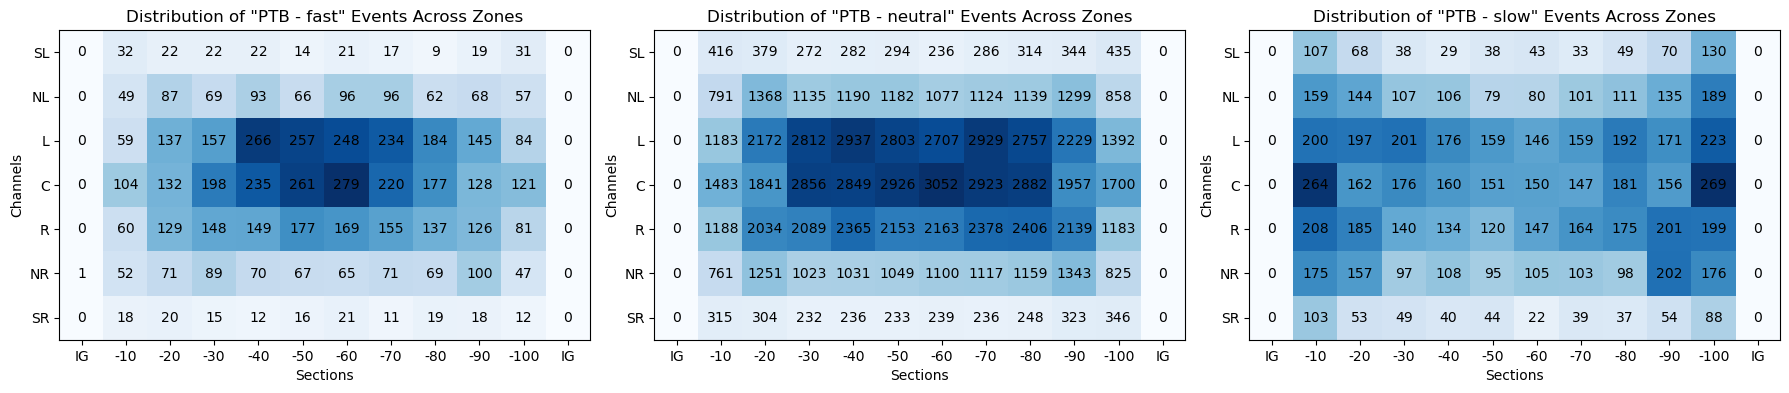

In [11]:
def plot_ptb_event_distribution(ptb_speed_df, event_name, ax):
    ptb_event_df = ptb_speed_df[ptb_speed_df['EventName'] == event_name]
    zone_counts = ptb_event_df.groupby('ZonePhysical').size().reset_index(name='Count')
    zone_count_dict = dict(zip(zone_counts['ZonePhysical'], zone_counts['Count']))

    grid_counts = np.zeros((7, 12), dtype=int)

    for zone, count in zone_count_dict.items():
        zone = int(zone)
        row = (zone - 1) % 7  # row index (0-based)
        col = (zone - 1) // 7  # column index (0-based)
        grid_counts[row, col] = count

    im = ax.imshow(grid_counts, cmap='Blues', origin='upper')

    for i in range(grid_counts.shape[0]):
        for j in range(grid_counts.shape[1]):
            count = grid_counts[i, j]
            ax.text(j, i, f'{count}', ha='center', va='center', color='black')

    channels = np.array(['SL', 'NL', 'L', 'C', 'R', 'NR', 'SR'])   
    sections = np.array(['IG', '-10', '-20', '-30', '-40', '-50', '-60', '-70', '-80', '-90', '-100', 'IG'])
    
    ax.set_xticks(np.arange(12))
    ax.set_xticklabels(sections)
    ax.set_yticks(np.arange(7))
    ax.set_yticklabels(channels)

    ax.set_title(f'Distribution of "{event_name}" Events Across Zones')
    ax.set_xlabel('Sections')
    ax.set_ylabel('Channels')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

plot_ptb_event_distribution(ptb_speed_df, 'PTB - fast', axes[0])
plot_ptb_event_distribution(ptb_speed_df, 'PTB - neutral', axes[1])
plot_ptb_event_distribution(ptb_speed_df, 'PTB - slow', axes[2])

plt.tight_layout()
plt.show()

By simply using 'Zones,' we can effectively convey spatial information, as depicted in the diagram above, which displays the counts of different play-the-ball speed events for each zone.

In [12]:
redundant_locational_features = ['XmPlayer', 'YmPlayer', 'ChannelPlayer', 'SectionPlayer',
                                 'XmPossession', 'YmPossession', 'ChannelPossession', 'SectionPossession',
                                 'XmPhysical', 'YmPhysical', 'ChannelPhysical', 'SectionPhysical']

ptb_speed_df = ptb_speed_df.drop(columns=redundant_locational_features)

### Qualifier Standardization and Renaming 

After filtering the dataset to include only rows related to play-the-ball speed, we observed that the qualifiers for each event are now consistent across the dataset, rendering the *Qualifier[1-8]Name* columns redundant.

Thus, we can remove *Qualifier[1-8]Name* columns and simply rename *Qualifier[1-9]* columns to their respective qualifier name.

In [13]:
for i in range(1, 9):
    qualifier_col = f'Qualifier{i}'
    qualifier_name_col = f'Qualifier{i}Name'
    
    if qualifier_name_col in ptb_speed_df.columns and qualifier_col in ptb_speed_df.columns:
        if ptb_speed_df[qualifier_name_col].nunique() == 1:
            print(f'All values in {qualifier_name_col} are the same: {ptb_speed_df[qualifier_name_col].iloc[0]}')
            new_name = ptb_speed_df[qualifier_name_col].iloc[0]
            
            ptb_speed_df.rename(columns={qualifier_col: new_name}, inplace=True)
            print(f'Column Qualifier{i} has been renamed to {new_name}.')
            
            ptb_speed_df.drop([qualifier_name_col], axis=1, inplace=True)
            print(f'Column {qualifier_name_col} has been dropped.')
            
        else:
            print(f'Values in {qualifier_name_col} are not the same.')

All values in Qualifier1Name are the same: PTB Tackle Result
Column Qualifier1 has been renamed to PTB Tackle Result.
Column Qualifier1Name has been dropped.
All values in Qualifier2Name are the same: PTB Contest
Column Qualifier2 has been renamed to PTB Contest.
Column Qualifier2Name has been dropped.
All values in Qualifier3Name are the same: Set Type
Column Qualifier3 has been renamed to Set Type.
Column Qualifier3Name has been dropped.
All values in Qualifier4Name are the same: Total Involved Tacklers
Column Qualifier4 has been renamed to Total Involved Tacklers.
Column Qualifier4Name has been dropped.
All values in Qualifier5Name are the same: PTB Defence
Column Qualifier5 has been renamed to PTB Defence.
Column Qualifier5Name has been dropped.
All values in Qualifier6Name are the same: PTB Outcome
Column Qualifier6 has been renamed to PTB Outcome.
Column Qualifier6Name has been dropped.
All values in Qualifier7Name are the same: PTB Ultimate Outcome
Column Qualifier7 has been ren

### Dummy Creation

As we see below, the *Deidentified Club Home/Away Name*, each contains the name of the home and away club for the game. We can therefore use these columns to make a dummy. The dummy is a dummy for the home club. If the club is homeclub, then it will be 1, and if it is away club, then 0.

In [14]:
ptb_speed_df[['Club Id', 'Club Name', 'Deidentified Away Club Id','Deidentified Away Club Name','Deidentified Club Home Id', 'Deidentified Club Home Name','TeamAId','TeamBId']]

,Club Id,Club Name,Deidentified Away Club Id,Deidentified Away Club Name,Deidentified Club Home Id,Deidentified Club Home Name,TeamAId,TeamBId
39,837e03d56b4dba3b8a4a5425c0420abd,Groots,0d68c832f3fa27f411e99d1b3985ce18,Unicorns,837e03d56b4dba3b8a4a5425c0420abd,Groots,500012,500004
70,837e03d56b4dba3b8a4a5425c0420abd,Groots,0d68c832f3fa27f411e99d1b3985ce18,Unicorns,837e03d56b4dba3b8a4a5425c0420abd,Groots,500012,500004
107,837e03d56b4dba3b8a4a5425c0420abd,Groots,0d68c832f3fa27f411e99d1b3985ce18,Unicorns,837e03d56b4dba3b8a4a5425c0420abd,Groots,500012,500004
138,837e03d56b4dba3b8a4a5425c0420abd,Groots,0d68c832f3fa27f411e99d1b3985ce18,Unicorns,837e03d56b4dba3b8a4a5425c0420abd,Groots,500012,500004
169,837e03d56b4dba3b8a4a5425c0420abd,Groots,0d68c832f3fa27f411e99d1b3985ce18,Unicorns,837e03d56b4dba3b8a4a5425c0420abd,Groots,500012,500004
...,...,...,...,...,...,...,...,...
4619292,f38f7f087f646c38c0207f1b2af32f12,Pandas,f38f7f087f646c38c0207f1b2af32f12,Pandas,980c9c368ae4f1129ea0a6fdd711fa8f,Devils,500028,500013
4619330,f38f7f087f646c38c0207f1b2af32f12,Pandas,f38f7f087f646c38c0207f1b2af32f12,Pandas,980c9c368ae4f1129ea0a6fdd711fa8f,Devils,500028,500013
4619360,f38f7f087f646c38c0207f1b2af32f12,Pandas,f38f7f087f646c38c0207f1b2af32f12,Pandas,980c9c368ae4f1129ea0a6fdd711fa8f,Devils,500028,500013
4619384,f38f7f087f646c38c0207f1b2af32f12,Pandas,f38f7f087f646c38c0207f1b2af32f12,Pandas,980c9c368ae4f1129ea0a6fdd711fa8f,Devils,500028,500013


In [15]:
ptb_speed_df['IsHome'] = np.where(ptb_speed_df['Club Name'] == ptb_speed_df['Deidentified Club Home Name'], 1, 0)

In [16]:
ptb_speed_df[['IsHome','Club Id', 'Club Name', 'Deidentified Away Club Id','Deidentified Away Club Name','Deidentified Club Home Id', 'Deidentified Club Home Name']]

,IsHome,Club Id,Club Name,Deidentified Away Club Id,Deidentified Away Club Name,Deidentified Club Home Id,Deidentified Club Home Name
39,1,837e03d56b4dba3b8a4a5425c0420abd,Groots,0d68c832f3fa27f411e99d1b3985ce18,Unicorns,837e03d56b4dba3b8a4a5425c0420abd,Groots
70,1,837e03d56b4dba3b8a4a5425c0420abd,Groots,0d68c832f3fa27f411e99d1b3985ce18,Unicorns,837e03d56b4dba3b8a4a5425c0420abd,Groots
107,1,837e03d56b4dba3b8a4a5425c0420abd,Groots,0d68c832f3fa27f411e99d1b3985ce18,Unicorns,837e03d56b4dba3b8a4a5425c0420abd,Groots
138,1,837e03d56b4dba3b8a4a5425c0420abd,Groots,0d68c832f3fa27f411e99d1b3985ce18,Unicorns,837e03d56b4dba3b8a4a5425c0420abd,Groots
169,1,837e03d56b4dba3b8a4a5425c0420abd,Groots,0d68c832f3fa27f411e99d1b3985ce18,Unicorns,837e03d56b4dba3b8a4a5425c0420abd,Groots
...,...,...,...,...,...,...,...
4619292,0,f38f7f087f646c38c0207f1b2af32f12,Pandas,f38f7f087f646c38c0207f1b2af32f12,Pandas,980c9c368ae4f1129ea0a6fdd711fa8f,Devils
4619330,0,f38f7f087f646c38c0207f1b2af32f12,Pandas,f38f7f087f646c38c0207f1b2af32f12,Pandas,980c9c368ae4f1129ea0a6fdd711fa8f,Devils
4619360,0,f38f7f087f646c38c0207f1b2af32f12,Pandas,f38f7f087f646c38c0207f1b2af32f12,Pandas,980c9c368ae4f1129ea0a6fdd711fa8f,Devils
4619384,0,f38f7f087f646c38c0207f1b2af32f12,Pandas,f38f7f087f646c38c0207f1b2af32f12,Pandas,980c9c368ae4f1129ea0a6fdd711fa8f,Devils


We can now remove the collumns: *Deidentified Away Club Id*, *Deidentified Away Club Name*,*Deidentified Club Home Id* and *Deidentified Club Home Name* since we have feature OppositionId which we can tell is home or away simply by looking at the converse of the *IsHome* feature.

E.g. if for a certain event, there is *Club Id* associated with the team 'Unicorns' *Opposition Id* associated with the team 'Pandas' and *IsHome* is 1, then we know that 'Unicorns' are the home team and thus, 'Pandas' must be the away team.

In [17]:
ptb_speed_df = ptb_speed_df.drop(['Deidentified Away Club Id','Deidentified Away Club Name','Deidentified Club Home Id', 'Deidentified Club Home Name'], axis=1)

### Label Encoding

Several categorical features in the dataset can be numerically represented as follows:

* *PTB Tackle Result*:
    * 'Won' → 1
    * 'Lost' → 0

* *Total Involved Tacklers*:
    * 'n eff. tacklers involved' (1 ≤ n ≤ 4) → n
    * '5+ eff. tacklers involved' → 5
    * 'Unknown eff. tacklers involved' → NaN

* *Set Type*:
    * 'Good ball' → 1
    * 'Yardage' → 0
    
* *PTB Defence*:
    * 'Defence set' → 1
    * 'Defence not set' → 0

* *Raw Tackle Number*:
    * 'Raw Tackle n' (1 ≤ n ≤ 7) → n
    * NaN → NaN

* *RunOn*:
    * 'Y' → 1
    * 'N' → 0

* *Captain*:
    * 'Y' → 1
    * 'N' → 0

In [18]:
ptb_speed_df['PTB Tackle Result Old'] = ptb_speed_df['PTB Tackle Result']
ptb_speed_df['PTB Tackle Result'] = ptb_speed_df['PTB Tackle Result'].map({'Won': 1, 'Lost': 0})
ptb_speed_df[['PTB Tackle Result Old', 'PTB Tackle Result']].head()

,PTB Tackle Result Old,PTB Tackle Result
39,Won,1
70,Lost,0
107,Lost,0
138,Lost,0
169,Won,1


In [19]:
ptb_speed_df = ptb_speed_df.drop(columns=['PTB Tackle Result Old'])

In [20]:
def convert_total_tacklers(value):
    if 'Unknown' in value:
        return np.nan
    elif '+' in value:
        return int(value.split('+')[0])
    else:
        return int(value.split()[0])

ptb_speed_df['Total Involved Tacklers Old'] = ptb_speed_df['Total Involved Tacklers']
ptb_speed_df['Total Involved Tacklers'] = ptb_speed_df['Total Involved Tacklers'].apply(convert_total_tacklers)
ptb_speed_df[['Total Involved Tacklers Old', 'Total Involved Tacklers']].head()

,Total Involved Tacklers Old,Total Involved Tacklers
39,3 eff. tacklers involved,3.0
70,3 eff. tacklers involved,3.0
107,3 eff. tacklers involved,3.0
138,3 eff. tacklers involved,3.0
169,1 eff. tackler involved,1.0


In [21]:
ptb_speed_df = ptb_speed_df.drop(columns=['Total Involved Tacklers Old'])

In [22]:
ptb_speed_df['Set Type Old'] = ptb_speed_df['Set Type']
ptb_speed_df['Set Type'] = ptb_speed_df['Set Type'].map({'Good ball': 1, 'Yardage': 0})
ptb_speed_df[['Set Type Old', 'Set Type']].head()

,Set Type Old,Set Type
39,Yardage,0
70,Yardage,0
107,Yardage,0
138,Yardage,0
169,Yardage,0


In [23]:
ptb_speed_df = ptb_speed_df.drop(columns=['Set Type Old'])

In [24]:
ptb_speed_df['PTB Defence Old'] = ptb_speed_df['PTB Defence']
ptb_speed_df['PTB Defence'] = ptb_speed_df['PTB Defence'].map({'Defence set': 1, 'Defence not set': 0})
ptb_speed_df[['PTB Defence Old', 'PTB Defence']].head()

,PTB Defence Old,PTB Defence
39,Defence set,1.0
70,Defence set,1.0
107,Defence set,1.0
138,Defence set,1.0
169,Defence not set,0.0


In [25]:
ptb_speed_df = ptb_speed_df.drop(columns=['PTB Defence Old'])

In [26]:
def convert_tackle_number(value):
    if pd.isna(value):
        return np.nan
    else:
        return int(value.split()[-1])

ptb_speed_df['Raw Tackle Number Old'] = ptb_speed_df['Raw Tackle Number']
ptb_speed_df['Raw Tackle Number'] = ptb_speed_df['Raw Tackle Number'].apply(convert_tackle_number)
ptb_speed_df[['Raw Tackle Number Old', 'Raw Tackle Number']].head()

,Raw Tackle Number Old,Raw Tackle Number
39,Raw Tackle 1,1.0
70,Raw Tackle 2,2.0
107,Raw Tackle 3,3.0
138,Raw Tackle 4,4.0
169,Raw Tackle 5,5.0


In [27]:
ptb_speed_df = ptb_speed_df.drop(columns=['Raw Tackle Number Old'])

In [28]:
ptb_speed_df['RunOn Old'] = ptb_speed_df['RunOn']
ptb_speed_df['RunOn'] = ptb_speed_df['RunOn'].map({'Y': 1, 'N': 0})
ptb_speed_df[['RunOn Old', 'RunOn']].head()

,RunOn Old,RunOn
39,Y,1
70,Y,1
107,Y,1
138,Y,1
169,Y,1


In [29]:
ptb_speed_df = ptb_speed_df.drop(columns=['RunOn Old'])

In [30]:
ptb_speed_df['Captain Old'] = ptb_speed_df['Captain']
ptb_speed_df['Captain'] = ptb_speed_df['Captain'].map({'Y': 1, 'N': 0})
ptb_speed_df[['Captain Old', 'Captain']].head()

,Captain Old,Captain
39,Y,1
70,N,0
107,N,0
138,N,0
169,N,0


In [31]:
ptb_speed_df = ptb_speed_df.drop(columns=['Captain Old'])

In [32]:
ptb_speed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112027 entries, 39 to 4619416
Data columns (total 51 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Anonymize 1PlayerId      111995 non-null  object 
 1   Away Score               112027 non-null  int64  
 2   Captain                  112027 non-null  int64  
 3   Club Id                  112027 non-null  object 
 4   Club Name                112027 non-null  object 
 5   DistanceMs               0 non-null       float64
 6   DurationSecs             112027 non-null  float64
 7   EventCode                112027 non-null  object 
 8   EventName                112027 non-null  object 
 9   Half                     112027 non-null  int64  
 10  Home Score               112027 non-null  int64  
 11  InPossessionClub Id      32 non-null      object 
 12  InPossessionPlayerId     32 non-null      float64
 13  MatchId                  112027 non-null  int64  
 14  Ma

### Low-Value Feature Removal

* *MatchMinute*

    * The *MatchMinute* feature indicates the minute of the year when the match kicked off in local time. However, it lacks critical context, such as *MatchYear*, *MatchMonth*, *MatchDay*, and *MatchHour*. Without these additional features, the *MatchMinute* value alone is not meaningful for analysis or interpretation.

* *DistanceMs*

    * The *DistanceMs* feature represents the distance in meters related to the current event. Since there is no distance associated with play-the-ball speed, this feature is not relevant and will be removed.

* *Points*

    * The *Points* column contains no usable data, as all values are null. Therefore, this feature will be removed.

* *InPossessionClubId* and *InPossessionPlayerId*

    * These features only have 32 rows of usable data, making them inadequate for meaningful analysis. As such, they will be removed.

* *TeamAId*, *TeamAPossessionSecs*, *TeamBId*, and *TeamBPossessionSecs*

    * Possession time for each team can already be derived from the *PossessionSecs* and *OppPossessionSecs* features. Additionally, *TeamAId* and *TeamBId* lack detailed descriptions in the source dictionary, rendering them uninformative. Therefore, these features will be removed.

* *SeriesId*

    * *SeriesId* only contains one unique value (111)

In [33]:
ptb_speed_df = ptb_speed_df.drop(['MatchMinute','DistanceMs','Points', 'InPossessionClub Id', 'InPossessionPlayerId', 'TeamAId', 'TeamAPossessionSecs', 'TeamBId', 'TeamBPossessionSecs', 'SeriesId'], axis=1)

In [34]:
ptb_speed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112027 entries, 39 to 4619416
Data columns (total 41 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Anonymize 1PlayerId      111995 non-null  object 
 1   Away Score               112027 non-null  int64  
 2   Captain                  112027 non-null  int64  
 3   Club Id                  112027 non-null  object 
 4   Club Name                112027 non-null  object 
 5   DurationSecs             112027 non-null  float64
 6   EventCode                112027 non-null  object 
 7   EventName                112027 non-null  object 
 8   Half                     112027 non-null  int64  
 9   Home Score               112027 non-null  int64  
 10  MatchId                  112027 non-null  int64  
 11  OfficialId               112027 non-null  int64  
 12  Opposition Id            112027 non-null  object 
 13  OppPossessionSecs        112027 non-null  float64
 14  Op

### Feature Engineering

An essential feature to incorporate into our dataset is CurrentMargin, which represents the difference between the current team's score and the opposition's score. This value is positive when the current team is winning, zero in the event of a draw, and negative if the opposition is ahead.

The CurrentMargin provides valuable insights for coaches and players, allowing them to adjust their strategies based on the score difference. Teams that are trailing by a small margin may opt for more aggressive tactics to level the game or seize the lead, while those in the lead might prioritize maintaining possession and defensive play. Research indicates that game context, particularly score margin, plays a critical role in shaping play calling and decision-making (Berri & Schmidt, 2010).

Additionally, margin analysis sheds light on player performance under pressure. Understanding how players perform when their team is ahead or behind can inform play-making decisions and player responsibility in different situations. Studies have shown that player performance varies significantly depending on the game context particularly score margins (Hoffmann et al., 2015).

*Berri, D. J., & Schmidt, M. B. (2010). The Wages of Wins: Taking Measure of the Many Myths in Modern Sport. Stanford University Press.*

*Hoffmann, R., Dvorak, J., & Eirale, C. (2015). The relationship between game performance and match outcome in elite rugby union. International Journal of Sports Science & Coaching, 10(1), 31-39.*


In [35]:
ptb_speed_df['CurrentMargin'] = ptb_speed_df['Score'] - ptb_speed_df['OppScore']

In [36]:
ptb_speed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112027 entries, 39 to 4619416
Data columns (total 42 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Anonymize 1PlayerId      111995 non-null  object 
 1   Away Score               112027 non-null  int64  
 2   Captain                  112027 non-null  int64  
 3   Club Id                  112027 non-null  object 
 4   Club Name                112027 non-null  object 
 5   DurationSecs             112027 non-null  float64
 6   EventCode                112027 non-null  object 
 7   EventName                112027 non-null  object 
 8   Half                     112027 non-null  int64  
 9   Home Score               112027 non-null  int64  
 10  MatchId                  112027 non-null  int64  
 11  OfficialId               112027 non-null  int64  
 12  Opposition Id            112027 non-null  object 
 13  OppPossessionSecs        112027 non-null  float64
 14  Op

### Correlation Analysis

Correlation between numerical features

In [37]:
numerical_cols = ptb_speed_df.select_dtypes(include=[np.number])

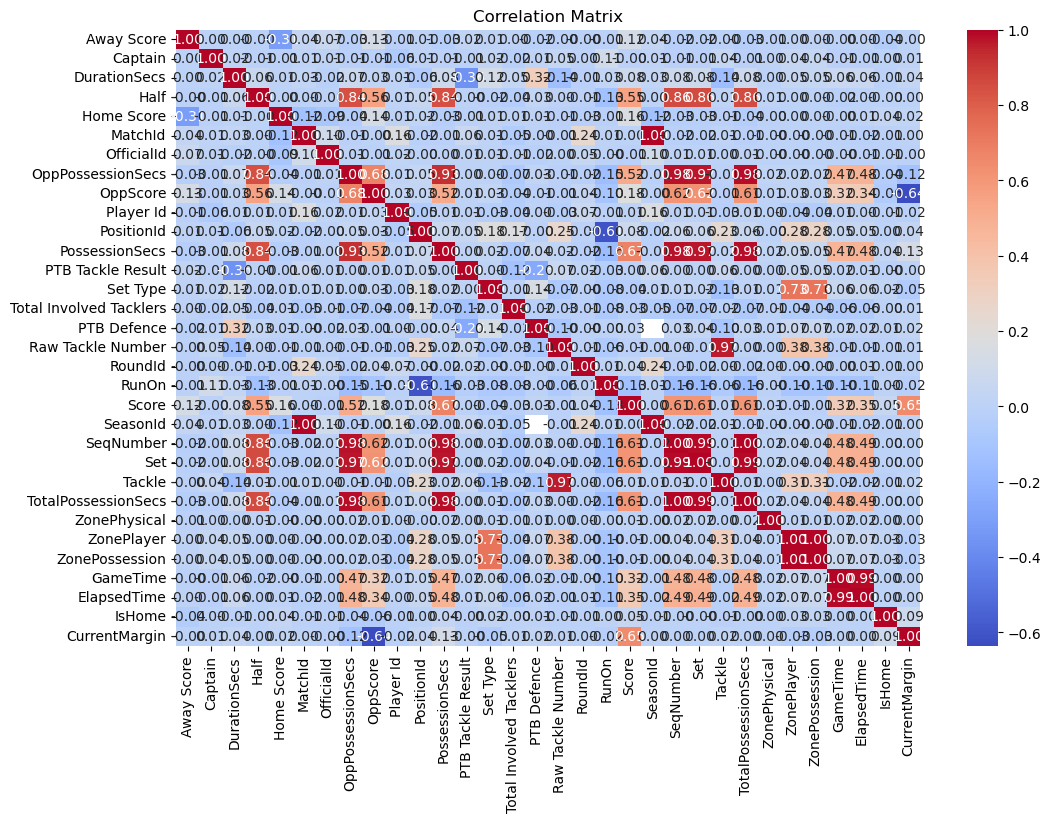

In [38]:
corr_matrix = numerical_cols.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [39]:
threshold = 0.8
high_corr_num_features = np.where(abs(corr_matrix) >= threshold)
high_corr_num_features = [(corr_matrix.columns[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) for x, y in zip(*high_corr_num_features) if x != y and x < y]

print("Highly correlated numerical feature pairs:\n")
for feature1, feature2, corr_coeff in high_corr_num_features:
    print(f"- {feature1} and {feature2} (Correlation Coefficient: {corr_coeff:.2f})")

Highly correlated numerical feature pairs:

- Half and OppPossessionSecs (Correlation Coefficient: 0.84)
- Half and PossessionSecs (Correlation Coefficient: 0.84)
- Half and SeqNumber (Correlation Coefficient: 0.86)
- Half and Set (Correlation Coefficient: 0.86)
- Half and TotalPossessionSecs (Correlation Coefficient: 0.86)
- MatchId and SeasonId (Correlation Coefficient: 1.00)
- OppPossessionSecs and PossessionSecs (Correlation Coefficient: 0.93)
- OppPossessionSecs and SeqNumber (Correlation Coefficient: 0.98)
- OppPossessionSecs and Set (Correlation Coefficient: 0.97)
- OppPossessionSecs and TotalPossessionSecs (Correlation Coefficient: 0.98)
- PossessionSecs and SeqNumber (Correlation Coefficient: 0.98)
- PossessionSecs and Set (Correlation Coefficient: 0.97)
- PossessionSecs and TotalPossessionSecs (Correlation Coefficient: 0.98)
- Raw Tackle Number and Tackle (Correlation Coefficient: 0.97)
- SeqNumber and Set (Correlation Coefficient: 0.99)
- SeqNumber and TotalPossessionSecs (C

Keep

* ZonePossession

Remove

* ZonePlayer

Correlation between categorical features 

In [40]:
categorical_cols = ptb_speed_df.select_dtypes(include=['object', 'category']).columns

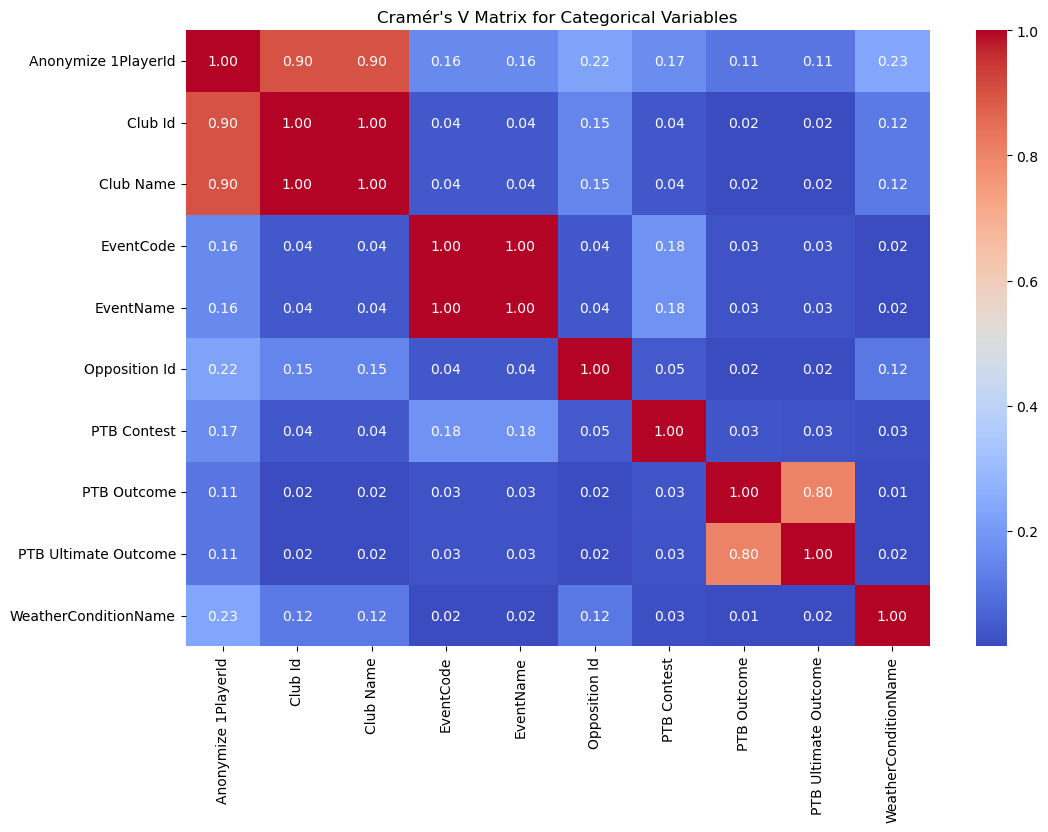

In [41]:
def cramers_v(x, y):
    x, y = x.dropna(), y.dropna()
    
    if len(x.unique()) == 1 or len(y.unique()) == 1:
        return np.nan
    
    confusion_matrix = pd.crosstab(x, y)
    
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

cramers_v_matrix = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(ptb_speed_df[col1], ptb_speed_df[col2])

cramers_v_matrix = cramers_v_matrix.astype(float)

plt.figure(figsize=(12, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cramér's V Matrix for Categorical Variables")
plt.show()

In [42]:
threshold = 0.8
high_corr_cat_features = np.where(abs(cramers_v_matrix) >= threshold)
high_corr_cat_features = [(cramers_v_matrix.columns[x], cramers_v_matrix.columns[y]) for x, y in zip(*high_corr_cat_features) if x != y and x < y]

print("Highly correlated categorical feature pairs:\n")
for feature1, feature2 in high_corr_cat_features:
    print(f"- {feature1} and {feature2} (Correlation Coefficient: {corr_coeff:.2f})")

Highly correlated categorical feature pairs:

- Anonymize 1PlayerId and Club Id (Correlation Coefficient: 0.99)
- Anonymize 1PlayerId and Club Name (Correlation Coefficient: 0.99)
- Club Id and Club Name (Correlation Coefficient: 0.99)
- EventCode and EventName (Correlation Coefficient: 0.99)
- PTB Outcome and PTB Ultimate Outcome (Correlation Coefficient: 0.99)


Keep:

- *Anonymize 1PlayerId* (useful for player-specific analysis)
- *EventName* (more descriptive and interpretable than EventCode)
- *ClubId*
- *PTB Ultimate Outcome* (likely more comprehensive and reflective of the final play result)

Remove:

- *Captain* (likely redundant as captaincy can be deduced from the player's role in other contexts)
- *EventCode*
- *Club Name* (redundant since ClubID is retained)
- *PTB Outcome* (might be a step before the final outcome)


In [43]:
cols_to_drop = ['ZonePlayer', 'Captain', 'EventCode', 'Club Name', 'PTB Outcome']
ptb_speed_df = ptb_speed_df.drop(columns=cols_to_drop)
ptb_speed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112027 entries, 39 to 4619416
Data columns (total 37 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Anonymize 1PlayerId      111995 non-null  object 
 1   Away Score               112027 non-null  int64  
 2   Club Id                  112027 non-null  object 
 3   DurationSecs             112027 non-null  float64
 4   EventName                112027 non-null  object 
 5   Half                     112027 non-null  int64  
 6   Home Score               112027 non-null  int64  
 7   MatchId                  112027 non-null  int64  
 8   OfficialId               112027 non-null  int64  
 9   Opposition Id            112027 non-null  object 
 10  OppPossessionSecs        112027 non-null  float64
 11  OppScore                 112027 non-null  float64
 12  Player Id                112027 non-null  float64
 13  PositionId               112027 non-null  float64
 14  Po

# Execute the command below to download the dataset

In [44]:
ptb_speed_df.to_csv('ptb_data.csv', index=False)

Final dataset description

| **Feature Number** | **Feature Name**         | **Data Type**  | **Description**   |
|--------------------|--------------------------|----------------|---------------------------|
| 1                  | Anonymize 1PlayerId       | object         | An anonymized identifier of the player  |
| 2                  | Away Score                | int64          | The current score of the away team |
| 3                  | Club Id                   | object         | The unique identifier for the club |
| 4                  | DurationSecs              | float64        | The duration in seconds relating to the current event |
| 5                  | EventName                 | object         | The name of the event |
| 6                  | Half                      | int64          | The half of the match. This could be > 2 if extra time is played |
| 7                  | Home Score                | int64          | The current score of the home team |
| 8                  | MatchId                   | int64          | The unique identifier of the match |
| 9                  | OfficialId                | int64          | The unique identifier of the official |
| 10                 | Opposition Id             | object         | The unique identifier of the opposition club |
| 11                 | OppPossessionSecs         | float64        | The running total of the seconds in possession for the team not in possession |
| 12                 | OppScore                  | float64        | The current score of the current event's opposition team |
| 13                 | Player Id                 | float64        | The unique identifier of the player |
| 14                 | PositionId                | float64        | The unique identifier of the player's position in this match |
| 15                 | PossessionSecs            | float64        | The running total of the seconds in possession for the team in possession |
| 16                 | PTB Tackle Result         | int64          | Value specifying whether the team won, 1, or lost, 0, the tackle |
| 17                 | PTB Contest               | object         | What happened to the player in the tackle |
| 18                 | Set Type                  | int64          | Good ball; 1, and Yardage; 0 |
| 19                 | Total Involved Tacklers   | float64        | The number of players involved in the tackle. A number between 1 and 5 |
| 20                 | PTB Defence               | float64        | Defence set; 1, and Defence not set; 0 |
| 21                 | PTB Ultimate Outcome      | object         | The final outcome of the tackle, eg. Try |
| 22                 | Raw Tackle Number         | float64        | The raw tackle number without the number of tackle being reset  |
| 23                 | RoundId                   | int64          | The number of the round |
| 24                 | RunOn                     | int64          | Value specifying whether the player was selected in the run-on players for this match. 1 for yes, and 0 for no |
| 25                 | Score                     | float64        | The current score of the current event's team |
| 26                 | SeasonId                  | int64          | The unique identifier of the season |
| 27                 | SeqNumber                 | int64          | A sequence number within the match ensuring events are in time-based order |
| 28                 | Set                       | int64          | The set number within the match. A number between 0 and 6. |
| 29                 | Tackle                    | int64          | The tackle number within the current set |
| 30                 | TotalPossessionSecs       | float64        | The running total of the total seconds in possession by either team |
| 31                 | WeatherConditionName      | object         | Weather condition reference data with one row per weather condition |
| 32                 | ZonePhysical              | int64          | The zone on the field in which the event occurred |
| 33                 | ZonePossession            | int64          | The zone on the field in which the event occurred |
| 34                 | GameTime                  | float64        | The time on the game clock in the current half, given in minutes |
| 35                 | ElapsedTime               | float64        | The elapsed time since the kickoff in the current half given in minutes |
| 36                 | IsHome                    | int64          | A dummy stating whether the club in the column *Club Id* is home team, 1, or away team, 0 |
| 37                 | CurrentMargin             | float64        | The difference between the current team’s score and the opposition’s score |

# Exploratory Data Analysis

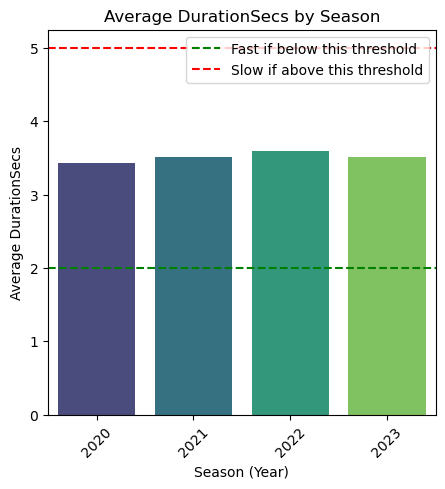

   SeasonID  AverageDurationSecs
0      2020             3.430660
1      2021             3.512339
2      2022             3.594115
3      2023             3.508932


In [45]:
season_ptb_speed_comp = ptb_speed_df.groupby('SeasonId')['DurationSecs'].mean().reset_index()

season_ptb_speed_comp.columns = ['SeasonID', 'AverageDurationSecs']

plt.figure(figsize=(5, 5))
sns.barplot(x='SeasonID', y='AverageDurationSecs', data=season_ptb_speed_comp, palette='viridis')

plt.xlabel('Season (Year)')
plt.ylabel('Average DurationSecs')
plt.title('Average DurationSecs by Season')
plt.xticks(rotation=45)

plt.axhline(y=2, color='green', linestyle='--', label='Fast if below this threshold')
plt.axhline(y=5, color='red', linestyle='--', label='Slow if above this threshold')

plt.legend()

plt.show()
print(season_ptb_speed_comp)

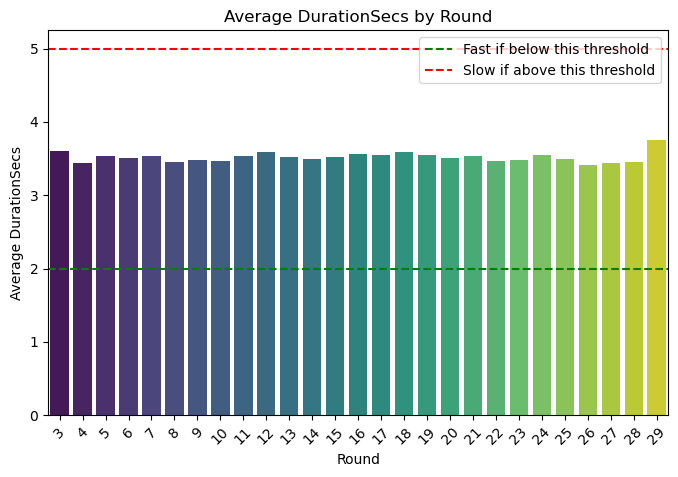

    RoundId  AverageDurationSecs
0         3             3.604585
1         4             3.444869
2         5             3.536450
3         6             3.515043
4         7             3.528786
5         8             3.455821
6         9             3.479405
7        10             3.470550
8        11             3.529821
9        12             3.596777
10       13             3.523730
11       14             3.491016
12       15             3.520759
13       16             3.566141
14       17             3.546591
15       18             3.596330
16       19             3.543705
17       20             3.503911
18       21             3.531956
19       22             3.468771
20       23             3.477167
21       24             3.545826
22       25             3.489461
23       26             3.407898
24       27             3.446705
25       28             3.447593
26       29             3.748553


In [46]:
round_ptb_speed_comp = ptb_speed_df.groupby('RoundId')['DurationSecs'].mean().reset_index()

round_ptb_speed_comp.columns = ['RoundId', 'AverageDurationSecs']

plt.figure(figsize=(8, 5))
sns.barplot(x='RoundId', y='AverageDurationSecs', data=round_ptb_speed_comp, palette='viridis')

plt.xlabel('Round')
plt.ylabel('Average DurationSecs')
plt.title('Average DurationSecs by Round')
plt.xticks(rotation=45)

plt.axhline(y=2, color='green', linestyle='--', label='Fast if below this threshold')
plt.axhline(y=5, color='red', linestyle='--', label='Slow if above this threshold')

plt.legend()

plt.show()
print(round_ptb_speed_comp)

## Factors affecting play-the-ball speed

### Random Forest Regressor

Using a random forest regressor we can create perform a feature importance analysis to galvanise the process of exploratory data analysis. This helps prioritise features to investigate in determining play-the-ball speed

Before implementing the regressor, we remove the following features from the dataset: *EventName*, *PTB Ultimate Outcome*, and *PTB Defence*. The *EventName* and *PTB Ultimate Outcome* features are not relevant to the analysis since they represent the outcomes of the play-the-ball rather than factors influencing the speed of play. Additionally, we exclude *PTB Defence* due to its high proportion of NaN values, which could distort the analysis. This feature can be investigated separately.

In [47]:
ptb_speed_factors_df = ptb_speed_df.drop(columns=['EventName', 'PTB Ultimate Outcome', 'PTB Defence'])

X = ptb_speed_factors_df.drop(columns=['DurationSecs'])
y = ptb_speed_factors_df['DurationSecs']
X_encoded = pd.get_dummies(X)
X_encoded_dropped = X_encoded.dropna()
y_dropped = y.loc[X_encoded_dropped.index]

X_train, X_test, y_train, y_test = train_test_split(X_encoded_dropped, y_dropped, test_size=0.2, random_state=42)

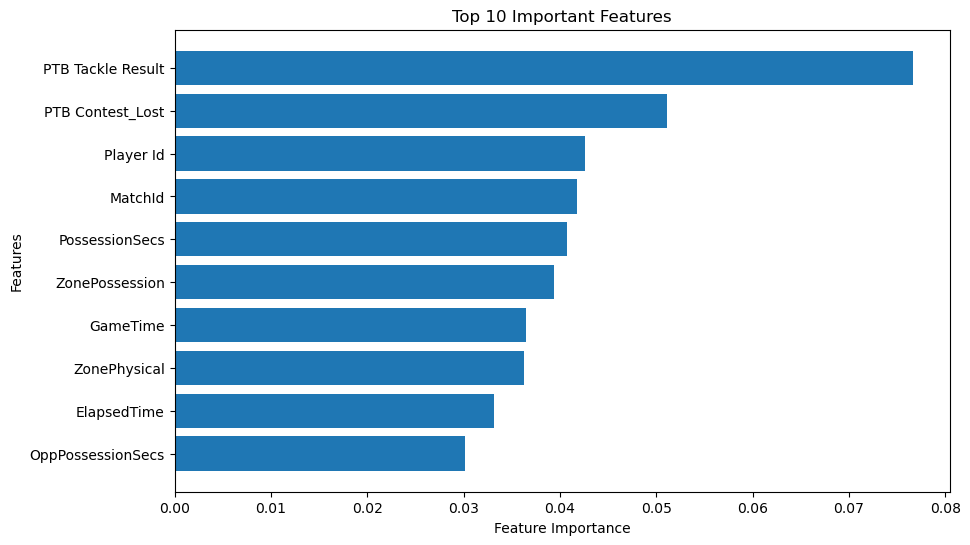

                           Feature    Importance
10               PTB Tackle Result  7.661791e-02
731               PTB Contest_Lost  5.108122e-02
7                        Player Id  4.256234e-02
3                          MatchId  4.178237e-02
9                   PossessionSecs  4.078313e-02
..                             ...           ...
276  Anonymize 1PlayerId_5f7bb984e  1.160894e-07
511  Anonymize 1PlayerId_bb5099a7f  8.562620e-08
342     Anonymize 1PlayerId_7a96dd  6.859430e-08
625     Anonymize 1PlayerId_e5a20d  3.972518e-08
257     Anonymize 1PlayerId_570ab8  0.000000e+00

[740 rows x 2 columns]


In [48]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features')
plt.gca().invert_yaxis()
plt.show()

print(feature_importances)

Text(0.5, 1.0, 'Average PTB Duration by PTB Tackle Result')

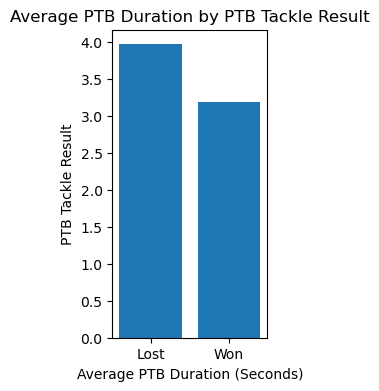

In [49]:
player_tackle_result_comp = ptb_speed_df.groupby('PTB Tackle Result')['DurationSecs'].mean().reset_index()
player_tackle_result_comp.columns = ['PTB Tackle Result', 'AvgDurationSecs']
player_tackle_result_comp['PTB Tackle Result'] = player_tackle_result_comp['PTB Tackle Result'].map({1: 'Won', 0: 'Lost'})

plt.figure(figsize=(2, 4))
plt.bar(player_tackle_result_comp['PTB Tackle Result'], player_tackle_result_comp['AvgDurationSecs'])

plt.xlabel('Average PTB Duration (Seconds)')
plt.ylabel('PTB Tackle Result')
plt.title('Average PTB Duration by PTB Tackle Result')

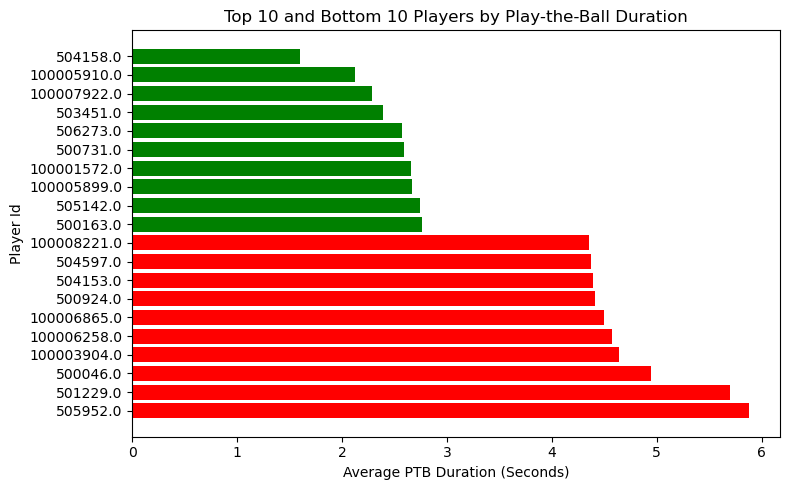

In [50]:
player_ptb_speed_comp = ptb_speed_df.groupby('Player Id')['DurationSecs'].mean().reset_index()
player_ptb_speed_comp.columns = ['Player Id', 'AvgDurationSecs']

player_ptb_speed_comp_sorted = player_ptb_speed_comp.sort_values(by='AvgDurationSecs', ascending=True)
top_10_players = player_ptb_speed_comp_sorted.head(10).copy()
bottom_10_players = player_ptb_speed_comp_sorted.tail(10).copy()

combined_players = pd.concat([top_10_players, bottom_10_players])

combined_players.loc[:, 'Player Id'] = combined_players['Player Id'].astype(str)

combined_players['Color'] = ['green'] * 10 + ['red'] * 10

plt.figure(figsize=(8, 5))
plt.barh(combined_players['Player Id'], combined_players['AvgDurationSecs'], color=combined_players['Color'])
plt.xlabel('Average PTB Duration (Seconds)')
plt.ylabel('Player Id')
plt.title('Top 10 and Bottom 10 Players by Play-the-Ball Duration')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

The PTB defence feature represents if the defence has been set in Yardage set type. Many teams rely on the fact that teams not setting their defensive line to make their up the field into scoring territory. A fast play-the-ball allows attacking teams to have an avantage over defending teams, whether from fatigue or poor line speed.



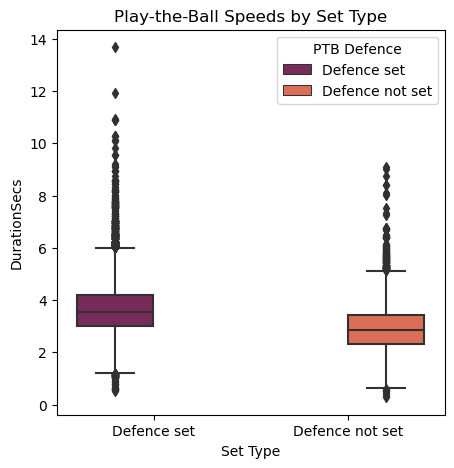

In [51]:
plt.figure(figsize=(5, 5))

sns.boxplot(x=ptb_speed_df['PTB Defence'].map({0: 'Defence not set', 1: 'Defence set'}), 
            y=ptb_speed_df['DurationSecs'], 
            data=ptb_speed_df, 
            palette='rocket',
            hue=ptb_speed_df['PTB Defence'].map({0: 'Defence not set', 1: 'Defence set'}))

plt.title('Play-the-Ball Speeds by Set Type')
plt.xlabel('Set Type')
plt.ylabel('DurationSecs')

plt.show()


## Effect of play-the-ball speed on game outcomes

In [52]:
ptb_speed_df['PTB Ultimate Outcome'].unique()

array(['Another PTB', 'Kick', 'Turnover', 'Opp ruck infringement', 'Try',
       'Handover', 'Penalty attack', 'Penalty defence', 'Other',
       'Field goal attempt'], dtype=object)

* Bad Outcomes: These outcomes generally result in a loss of possession or disadvantage to the team with the ball:

    * Turnover: Losing possession directly is a bad outcome.
    * Handover: The other team gains possession, which is a disadvantage.
    * Penalty defence: A penalty against the defending team gives the opposition an advantage.

* Neutral Outcomes: These outcomes neither significantly benefit nor disadvantage the team:

    * Another PTB: This means the play continues, so it's neutral.

* Positive Outcomes: These outcomes typically result in an advantage for the team with the ball or scoring opportunities:

    * Kick: A strategic kick could provide an opportunity to gain territory or retain possession.
    * Opp ruck infringement: The opposing team’s mistake during the ruck can result in a penalty or advantage for the attacking team.
    * Try: Scoring a try is a highly positive outcome.
    * Penalty attack: Gaining a penalty in attack is advantageous, as it can lead to a scoring opportunity.
    * Field goal attempt: Even though it's an attempt, it can result in points or field position, making it a positive outcome.

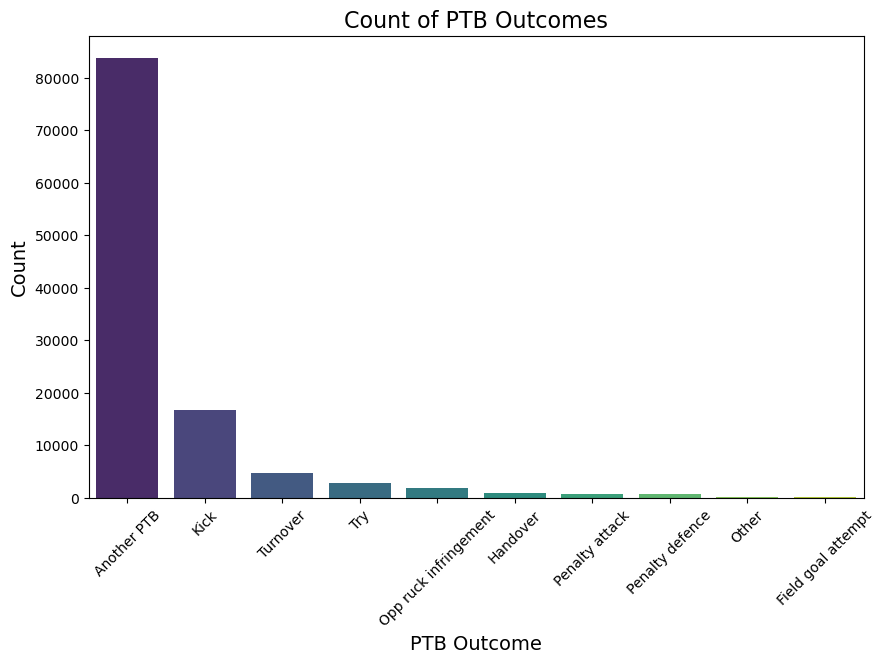

In [53]:
ptb_outcome_counts = ptb_speed_df['PTB Ultimate Outcome'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=ptb_outcome_counts.index, y=ptb_outcome_counts.values, palette='viridis')

plt.title('Count of PTB Outcomes', fontsize=16)
plt.xlabel('PTB Outcome', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45) 
plt.show()

In [54]:
bad_outcomes = ['Turnover', 'Handover', 'Penalty defence']
neutral_outcomes = ['Another PTB']
positive_outcomes = ['Kick', 'Opp ruck infringement', 'Try', 'Penalty attack', 'Field goal attempt']

Successful Outcomes: ['Kick', 'Opp ruck infringement', 'Try', 'Penalty attack', 'Field goal attempt']
Neutral Outcomes: ['Another PTB']
Unsuccessful Outcomes: ['Turnover', 'Handover', 'Penalty defence']


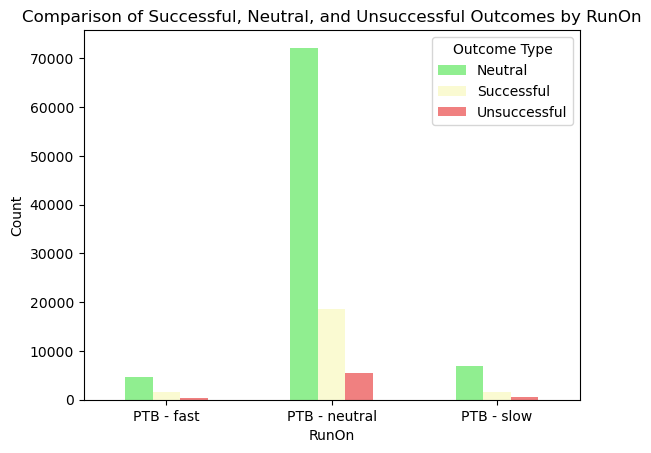

Outcome Type     Neutral  Successful  Unsuccessful
EventName                                         
PTB - fast     69.481766   24.272848      6.245386
PTB - neutral  74.960532   19.403822      5.635646
PTB - slow     77.535101   17.361266      5.103633


In [55]:
outcomes = ptb_speed_df[['EventName', 'PTB Ultimate Outcome']].copy()

print("Successful Outcomes:", positive_outcomes)
print("Neutral Outcomes:", neutral_outcomes)
print("Unsuccessful Outcomes:", bad_outcomes)

outcomes['Outcome Type'] = outcomes['PTB Ultimate Outcome'].apply(
    lambda x: 'Successful' if x in positive_outcomes 
               else ('Neutral' if x in neutral_outcomes else 'Unsuccessful')
)

outcome_counts = outcomes.groupby(['EventName', 'Outcome Type']).size().unstack(fill_value=0)

outcome_percentages = outcome_counts.div(outcome_counts.sum(axis=1), axis=0) * 100

ax = outcome_counts.plot(kind='bar', stacked=False, color=['lightgreen', 'lightgoldenrodyellow', 'lightcoral'])
plt.title('Comparison of Successful, Neutral, and Unsuccessful Outcomes by RunOn')
plt.xlabel('RunOn')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Outcome Type')

plt.show()

print(outcome_percentages)

In our data provided, there are two types of Set Types provided, Yardage and Good Ball. In the terms of Rugby League, sets which are considered Yardage are sets played to advance the ball deeper into enemy territory, where as Good Ball sets are sets inside of the scoring, where the attacking line is set, and their respective playmakers calling for a set play. We can see in the box-plot below that Yardage sets usually require fast play the balls, whereas Good Ball sets do not require as such. This is due to the fact that the playmakers need further time to set their team in place to run the set plays. However, during Yardage sets, teams rely on the having a play-the-ball leading to a defensive line not set.

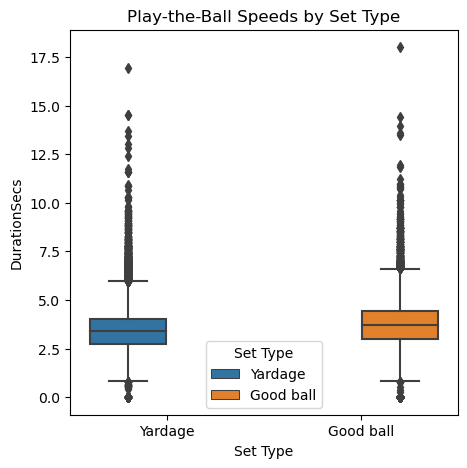

In [56]:
plt.figure(figsize=(5, 5))

sns.boxplot(x=ptb_speed_df['Set Type'].map({0: 'Yardage', 1: 'Good ball'}), 
            y=ptb_speed_df['DurationSecs'], 
            data=ptb_speed_df, 
            hue=ptb_speed_df['Set Type'].map({0: 'Yardage', 1: 'Good ball'}))

plt.title('Play-the-Ball Speeds by Set Type')
plt.xlabel('Set Type')
plt.ylabel('DurationSecs')

plt.show()